In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

from random import randint

Классификатор k-means (класс для обучения модели)

In [232]:
class k_means:
    def __init__(self, K, max_iter):
        self.K = K
        self.max_iter = max_iter
    
    def fit(self, X):
        X = np.array(X)
        if len(X.shape) == 1:
            M, N = X.shape[0], 1
        else:
            M, N = X.shape
    
        self.centroids = np.array([[0.0] * N for _ in range(self.K)])
        for j in range(self.K):
            self.centroids[j] = X[randint(0, M - 1)]
        
        for iteration in range(self.max_iter):
            centroids_old = [tuple(self.centroids[j]) for j in range(self.K)]
            
            dists = np.zeros((M, self.K)).astype(np.float32)
            for i in range(M):
                for j in range(self.K):
                    dists[i][j] = sum((X[i] - self.centroids[j]) ** 2)
            
            self.clusters = np.argmin(dists, axis=1)
            for j in range(self.K):
                for n in range(N):
                    if len(X[(self.clusters == j)]) == 0:
                        print('no points in cluster', j)
                        continue
                    self.centroids[j][n] = sum(X[(self.clusters == j)][:, n]) / len(X[(self.clusters == j)])
            
            if np.all(self.centroids == centroids_old):
                print('iteration', str(iteration), ': centroids have stopped moving')
                break
                
    def within_groups_variance(self, X):
        X = np.array(X)
        if len(X.shape) == 1:
            M, N = X.shape[0], 1
        else:
            M, N = X.shape
        within_groups = [0.0] * self.K
        
        for j in range(self.K):
            for n in range(N):
                within_groups[j] += sum((X[(self.clusters == j)][:, n] - self.centroids[j][n]) ** 2)
        return sum(within_groups)

Классификация ирисов (3 класса)

In [228]:
from sklearn.datasets import load_iris
iris = load_iris()
data = pd.DataFrame(data=iris.data, columns=iris.feature_names)
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [224]:
model = k_means(3, 100)
%time model.fit(data)
clusters = pd.Series(model.clusters)

iteration 12 : centroids have stopped moving
Wall time: 77.8 ms


In [225]:
model.centroids

array([[5.006     , 3.428     , 1.462     , 0.246     ],
       [6.85384615, 3.07692308, 5.71538462, 2.05384615],
       [5.88360656, 2.74098361, 4.38852459, 1.43442623]])

Результат кластеризации

In [226]:
clusters.value_counts().sort_index()

0    50
1    39
2    61
dtype: int64

Как должно быть

In [207]:
pd.Series(iris.target).value_counts().sort_index()

0    50
1    50
2    50
dtype: int64

С использованием реализации k-means в sklearn

In [213]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)
model.fit(data)
clusters = model.labels_

In [214]:
pd.Series(clusters).value_counts().sort_index()

0    62
1    50
2    38
dtype: int64

Классификация данных mnist/digits (рукописные цифры)

In [245]:
from sklearn.datasets import load_digits
mnist = load_digits()
data = pd.DataFrame(data=mnist.data)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [181]:
model = k_means(10, 1000)
%time model.fit(data)
clusters = pd.Series(model.clusters)
clusters.unique()

iteration 22 : centroids have stopped moving
Wall time: 24.2 s


array([0, 2, 1, 5, 6, 3, 9, 4, 8, 7], dtype=int64)

In [187]:
clusters.value_counts().sort_index()

0    179
1    179
2    224
3    182
4     88
5    167
6    248
7    147
8    175
9    208
dtype: int64

Должно быть так

In [188]:
pd.Series(mnist.target).value_counts().sort_index()

0    178
1    182
2    177
3    183
4    181
5    182
6    181
7    179
8    174
9    180
dtype: int64

Поиск оптимального числа кластеров

In [ ]:
max_n_clusters = 25
wss = [float('inf')] * max_n_clusters

for k in range(1, max_n_clusters + 1):
    model = k_means(k, 100)
    model.fit(data)
    clusters = pd.Series(model.clusters)
    wss[k - 1] = model.within_groups_variance(data)

Данные про ирисы: оптимальное число кластеров = 3

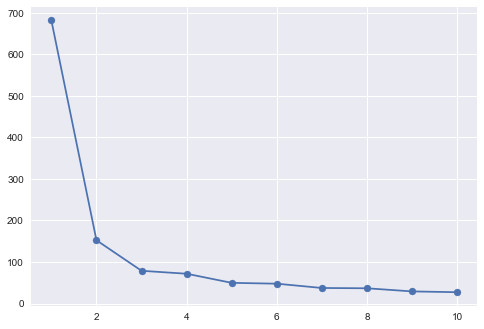

In [244]:
plt.scatter(range(1, max_n_clusters + 1), wss[:max_n_clusters])
plt.plot(range(1, max_n_clusters + 1), wss[:max_n_clusters])

Данные про рукописные цифры: оптимальное число кластеров = 10

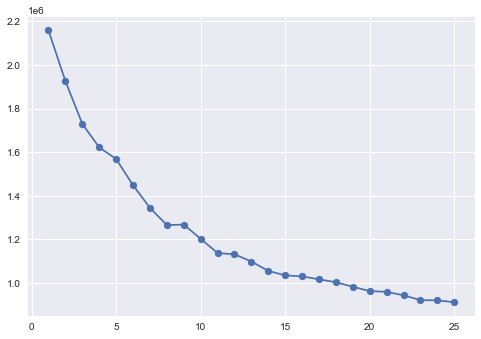

In [247]:
plt.scatter(range(1, max_n_clusters + 1), wss[:max_n_clusters])
plt.plot(range(1, max_n_clusters + 1), wss[:max_n_clusters])